# Session 4: Visualization of outputs
You will learn how to visualize the input/output datasets



In [1]:
# import pyIncore modules
from pyincore import IncoreClient, FragilityService, FragilityCurveSet, MappingSet, Dataset

In [2]:
# Connect to IN-CORE service
client = IncoreClient()

Connection successful to IN-CORE services. pyIncore version detected: 0.9.3


In [3]:
fragility_services = FragilityService(client)

## 1. Joining Dataset

Data preparation and data post-processing are common procedures. Prior to using pyIncore, users often encounter situation that they need to reshape their own dataset to make it compliant with the input dataset format of pyIncore. 

For example, adding GUID to inventory dataset. GUID (aka UUID) is an acronym for 'Globally Unique Identifier'. It is a 128-bit integer number used to identify resources. In IN-CORE We **require** each individual row/item in an inventory to have its own GUID. If your dataset does not come with GUID, pyIncore has utility method to help you add it.

After acquiring outputs from pyIncore analyses, often time user would need to perform data aggregation to gain statitical insights. The below tutorial gives a few examples on how to join datasets and generate some basic visualizations.

### Step 1: Running building dmg analysis (Tornado)

In [4]:
# create a local dataset with buiding inventory data
local_buildings = Dataset.from_file("sample_bldgs_w_guid.shp", data_type="ergo:buildingInventoryVer7")

In [5]:
# import building damage analysis class
from pyincore.analyses.buildingdamage import BuildingDamage

In [6]:
# Define the variables to be used for input parameters
hazard_type = "earthquake"
hazard_id = "5b902cb273c3371e1236b36b"
result_name = "memphis_eq_bldg_dmg_result"
mapping_id = "5b47b350337d4a3629076f2c"

# create fragility mapping object with id
eq_mapping_set = MappingSet(fragility_services.get_mapping(mapping_id))

# Create building damage analysis object
eq_bldg_dmg = BuildingDamage(client)

eq_bldg_dmg.set_input_dataset("buildings", local_buildings)
eq_bldg_dmg.set_input_dataset("dfr3_mapping_set", eq_mapping_set)
eq_bldg_dmg.set_parameter("result_name", result_name)
eq_bldg_dmg.set_parameter("hazard_type", hazard_type)
eq_bldg_dmg.set_parameter("hazard_id", hazard_id)
eq_bldg_dmg.set_parameter("num_cpu", 4)

# Run building damage analysis
eq_bldg_dmg.run_analysis()

True

In [7]:
eq_bldg_dmg.get_output_dataset("ds_result").get_dataframe_from_csv().head()

,guid,LS_0,LS_1,LS_2,DS_0,DS_1,DS_2,DS_3
0,ac8b0b44-ae82-4c48-afb8-076e2d16c7e5,0.848149,0.327322,2.722964e-02,0.151851,0.520827,0.300092,2.722964e-02
1,154b0a62-cae6-456d-8d90-635e3e1c2dcb,0.844343,0.328299,2.860543e-02,0.155657,0.516043,0.299694,2.860543e-02
2,9f9b11f8-c25c-4760-b1d2-a63bbeec8e72,0.896774,0.480925,8.756720e-02,0.103226,0.415849,0.393358,8.756720e-02
3,28321416-e473-473b-ad0a-c3c38248acc7,0.828098,0.293753,2.738378e-02,0.171902,0.534345,0.266369,2.738378e-02
4,b5069250-7a2b-47b1-9754-290528a6d72d,0.970343,0.154677,1.000000e-10,0.029657,0.815666,0.154677,1.000000e-10


### Step 2: Joining two datasets

In [8]:
# getting dataframe of damage output
eq_bldg_dmg_df = eq_bldg_dmg.get_output_dataset("ds_result").get_dataframe_from_csv()

# getting geodataframe of building dataset 
bldg_gdf = local_buildings.get_dataframe_from_shapefile()

# merge/join two dataframe
# you can choose columns to be merged
bldg_dmg_gdf = bldg_gdf[['guid', 'struct_typ', 'geometry']].merge(eq_bldg_dmg_df, on='guid')
bldg_dmg_gdf.head()

,guid,struct_typ,geometry,LS_0,LS_1,LS_2,DS_0,DS_1,DS_2,DS_3
0,ac8b0b44-ae82-4c48-afb8-076e2d16c7e5,C1,POINT (-90.02585 35.14020),0.848149,0.327322,2.722964e-02,0.151851,0.520827,0.300092,2.722964e-02
1,154b0a62-cae6-456d-8d90-635e3e1c2dcb,C1,POINT (-90.02585 35.14020),0.844343,0.328299,2.860543e-02,0.155657,0.516043,0.299694,2.860543e-02
2,9f9b11f8-c25c-4760-b1d2-a63bbeec8e72,S1,POINT (-90.01928 35.13640),0.896774,0.480925,8.756720e-02,0.103226,0.415849,0.393358,8.756720e-02
3,28321416-e473-473b-ad0a-c3c38248acc7,URM,POINT (-90.07377 35.12344),0.828098,0.293753,2.738378e-02,0.171902,0.534345,0.266369,2.738378e-02
4,b5069250-7a2b-47b1-9754-290528a6d72d,S1,POINT (-90.04349 35.15360),0.970343,0.154677,1.000000e-10,0.029657,0.815666,0.154677,1.000000e-10


## 2. Using Pandas

You can use Pandas and GeoPandas to dispaly tabular data and create charts. 
This secsion shows some examples.


In [9]:
# Stat summary on a column
bldg_dmg_gdf["LS_0"].describe()

count    22.000000
mean      0.828967
std       0.106217
min       0.590205
25%       0.759679
50%       0.850892
75%       0.888729
max       0.993698
Name: LS_0, dtype: float64

In [10]:
# Show table sorted by DS_3 (decending) and struct_typ (ascending)

bldg_dmg_gdf.sort_values(['DS_3', 'struct_typ'], ascending=[0,1]).head()

,guid,struct_typ,geometry,LS_0,LS_1,LS_2,DS_0,DS_1,DS_2,DS_3
14,6dd342ef-498c-43a9-85cd-35ad76e4c279,W2,POINT (-89.77456 35.20624),0.856181,0.446936,0.094468,0.143819,0.409244,0.352468,0.094468
2,9f9b11f8-c25c-4760-b1d2-a63bbeec8e72,S1,POINT (-90.01928 35.13640),0.896774,0.480925,0.087567,0.103226,0.415849,0.393358,0.087567
11,d7603d04-6917-478c-8bb7-50cf9118f973,S1,POINT (-89.86438 35.09755),0.880047,0.445912,0.074362,0.119953,0.434135,0.371550,0.074362
6,11395729-3727-449d-9848-778d68edd7d8,S1,POINT (-90.04349 35.15360),0.923829,0.491034,0.070220,0.076171,0.432794,0.420815,0.070220
21,3ef119b1-6432-4875-aa26-9dbf571388f1,S1,POINT (-89.80149 35.09272),0.891623,0.413491,0.047434,0.108377,0.478133,0.366056,0.047434


In [11]:
# Show table group by Structure type
grouped_bldg_dmg = bldg_dmg_gdf.groupby(by=['struct_typ'], as_index=True)\
.agg({'DS_0': 'mean', 'DS_1':'mean', 'DS_2': 'mean', 'DS_3': 'mean', 'guid': 'count'})
grouped_bldg_dmg.rename(columns={'guid': 'total_count'}, inplace=True)
grouped_bldg_dmg.head()

,DS_0,DS_1,DS_2,DS_3,total_count
struct_typ,,,,,
C1,0.188494,0.524856,0.264423,0.022226,7
C2,0.204050,0.519597,0.252735,0.023617,1
S1,0.137610,0.578995,0.249515,0.033880,11
URM,0.171902,0.534345,0.266369,0.027384,1
W2,0.276807,0.438296,0.234968,0.049929,2


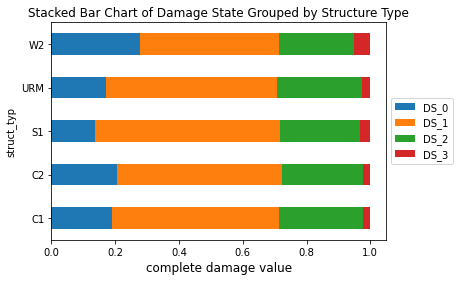

In [12]:
# Plot Damage state by structure type
ax = grouped_bldg_dmg[["DS_0", "DS_1", "DS_2", "DS_3"]].plot.barh(stacked=True)
ax.set_title("Stacked Bar Chart of Damage State Grouped by Structure Type", fontsize=12)
ax.set_xlabel("complete damage value", fontsize=12)
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5)) #here is the magic

Text(0, 0.5, 'counts')

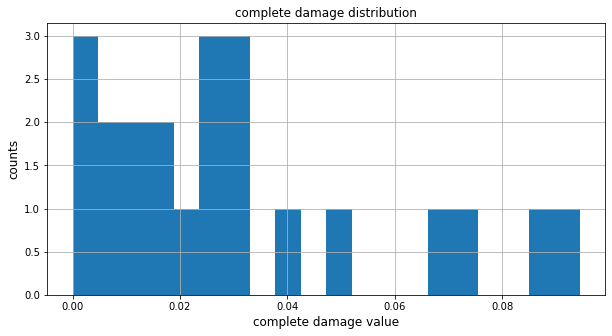

In [13]:
# Create a histogram with DS_3

ax = bldg_dmg_gdf['DS_3'].hist(bins=20, figsize=[10,5])
ax.set_title("complete damage distribution", fontsize=12)
ax.set_xlabel("complete damage value", fontsize=12)
ax.set_ylabel("counts", fontsize=12)

## 3. Using pyIncore-viz

pyIncore-viz is a Python visualization package for pyIncore module. It provides users with convenient methods to create image and graphic outputs of various hazard IN-CORE analyses.

### 3.1 Plotting Fragility curves

In [14]:
# visualize this fragility curve using pyincore-viz package
from pyincore_viz.plotutil import PlotUtil as plot

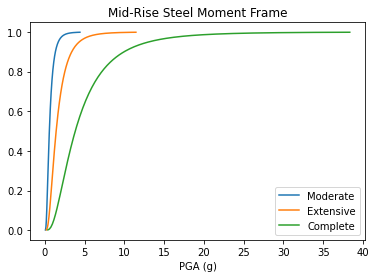

In [15]:
# Plot fragility curves

fragility_set_id = "5b47b2d7337d4a36187c61ce"

# Get local fragility curve set
fragility_curve_set = FragilityCurveSet(fragility_services.get_dfr3_set(fragility_set_id))
fragility_curve_set.fragility_curves

plt = plot.get_fragility_plot(fragility_curve_set, title="Mid-Rise Steel Moment Frame")
plt.show()

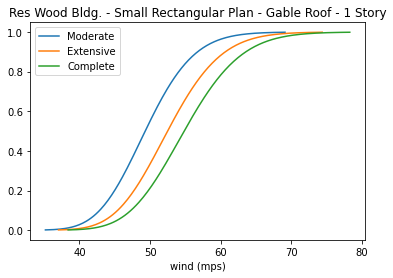

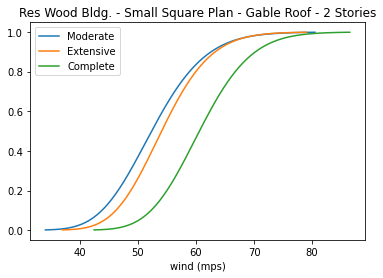

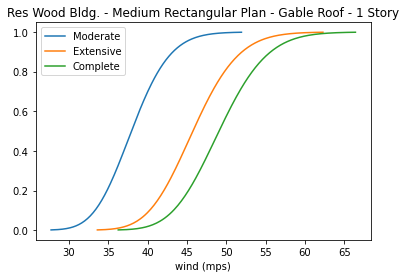

In [16]:
#plot fragility curves of tornado building by going through mapping

fragility_service = FragilityService(client)
mapping_id = "5d8942dfb9219c068ea795ea"
mapping_set = MappingSet(fragility_service.get_mapping(mapping_id))

# plot fragility for the first 3 archetypes using pyincore viz method
for mapping in mapping_set.mappings[:3]:
    fragility_id = mapping.entry['Non-Retrofit Fragility ID Code']
    fragility_set = FragilityCurveSet(fragility_service.get_dfr3_set(fragility_id))
    plt = plot.get_fragility_plot(fragility_set)
    plt.show()
    

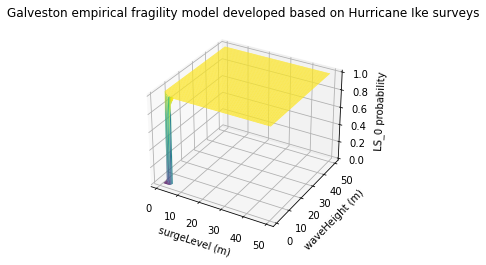

In [17]:
# Plot fragility curves (parametric curves)

# use utility method of pyicore-viz package to visulaize the fragility
fragility_set = FragilityCurveSet(FragilityService(client).get_dfr3_set("5f6ccf67de7b566bb71b202d"))
plt = plot.get_fragility_plot_3d_refactored(fragility_set, 
                                            title="Galveston empirical fragility model developed "
                                            "based on Hurricane Ike surveys",
                                            limit_state="LS_0")
plt.show()


### 3.2 Plot Geospatial Map

Plotting a geospatial map is generating static image of a map.

In [18]:
from pyincore_viz.geoutil import GeoUtil as geoviz


Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...


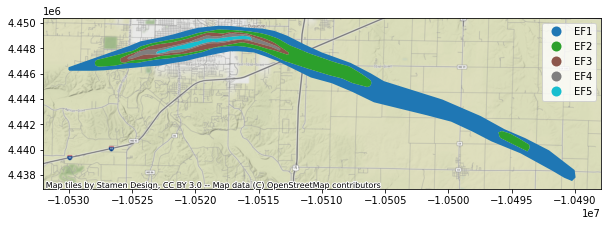

In [19]:
# Plot tornado path

tornado_path_id = "5d07cbeab9219c065b080930"
geoviz.plot_tornado(tornado_path_id, client, basemap=True)

Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...


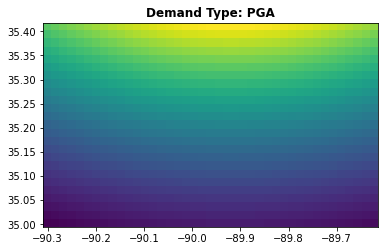

In [20]:
# Plot earthquake

eq_id = "5b902cb273c3371e1236b36b"
geoviz.plot_earthquake(eq_id, client)

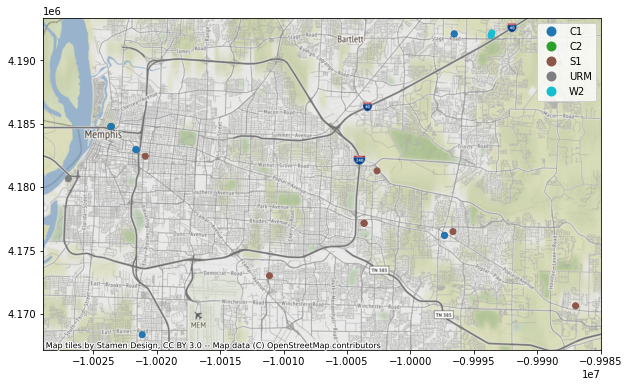

In [21]:
# Plot a map with a Dataset 
# with local dataset (local_buildings)

geoviz.plot_map(local_buildings, column='struct_typ',category='True')

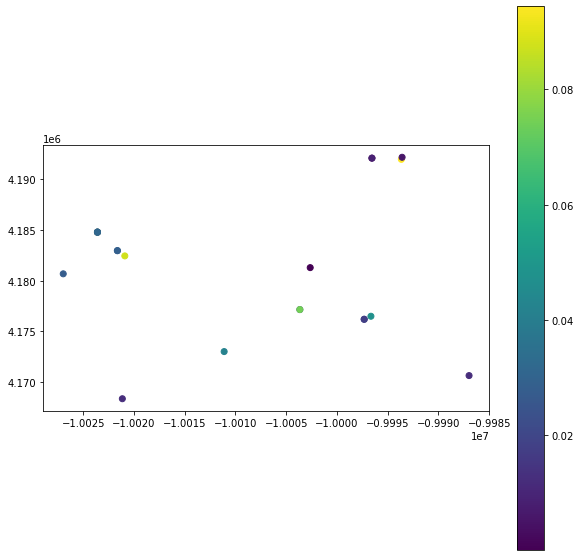

In [22]:
# Plot a map with GeoDataframe 

geoviz.plot_gdf_map(bldg_dmg_gdf, 'DS_3', basemap=False)

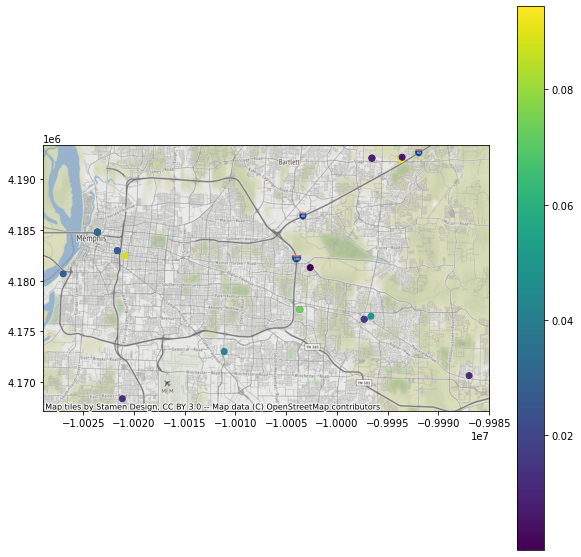

In [23]:
# Plot a map with GeoDataframe 

geoviz.plot_gdf_map(bldg_dmg_gdf, 'DS_3', basemap=True)

In [24]:
# Interactive map with Dataset
# addjust additional multiplier to increase the intensity of heatmap, e.g. multipler=1000 
map = geoviz.plot_heatmap_from_gdf(bldg_dmg_gdf, "DS_3", radius=7, blur=5, name="DS_3", multiplier=1000) 
map

Map(center=[0.0, 0.0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

## Hands-on Assignment

Please open [session4-assignment.ipynb](session4-assignment.ipynb).